<a href="https://colab.research.google.com/github/tmrb/Master-project-codes/blob/main/blocks_visualization_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJETO DISCIPLINA DE ALGORITMOS 1**

Aluno : Thiago Moura da Rocha Bastos

O objetivo desse trabalho e a utilização de dados de densidade óptica de perfis de filmes metálicos obtidos em processo industrial de metalização a vapor, para análise e classificação dos filmes produzido.

Motivação: Sabe-se que a densidade óptica dos filmes metálicos são variáveis essenciais para a qualidade do produto e a sua análise além de possibilitar predições de qualidade do produto formado, possibilita a análise das condições operacionais.

In [ ]:
from google.colab import drive
import sys
try:
  drive.mount("/content/drive", force_remount=True)
  root  = '/content/drive/My Drive/projeto'
  sys.path.append(root)
except:
  print('erro encontrado')

Mounted at /content/drive


In [ ]:
try:
  !pip install git+https://github.com/Borda/pyImSegm.git
  !pip install gco-wrapper
  !pip install shap
  !pip install --upgrade impedance
  !pip install keras
  !pip install git+https://github.com/divamgupta/image-segmentation-keras
except:
  print('Erro de instalação shap')

  Cloning https://github.com/Borda/pyImSegm.git to /tmp/pip-req-build-xc7odrdb
  Running command git clone -q https://github.com/Borda/pyImSegm.git /tmp/pip-req-build-xc7odrdb
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 563kB 11.5MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 645kB 18.2MB/s 
  Created wheel for ImSegm: filename=ImSegm-0.1.8-cp37-cp37m-linux_x86_64.whl size=514278 sha256=a4dadb9438bef38afa4af659106bf900f05b7cfdce7011a5f4e275704e18c8ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-tly_gpdj/wheels/a0/f3/67/a0f93bb9cd0b5e4c514982517e7fb87b122246c05e085bfa89
  Created wheel for olefile: filename=olefile-0.44-cp37-none-any.whl size=47817 sha256=e29f7814430662959a41d1ef49f8c56ce9c18e7fd32d9e1aa65834de77eeae81
  Stored in directory: /root/.cache/pip/wheels/c4/19/76/61fc7929d808e51567aff23036ca5fe6ba8336ad0559ca6a27
  Created wheel for planar: filename=planar-0.4-cp37-cp37

In [ ]:
from __future__ import print_function
%matplotlib inline
import pandas
import numpy 
import tensorflow as tf
import datetime
import shap
from typing import List
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os, sys, glob, time
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import imsegm.utilities.data_io as tl_data
import imsegm.pipelines as segm_pipe
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow.keras.backend as K
import random

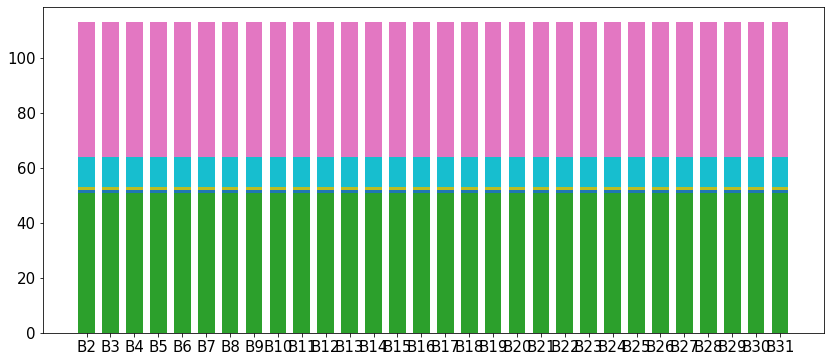

In [ ]:
#Coleta de dados da tabela com os valores de Densidade Óptica (DO)
try:
  dbo_blocks= pandas.read_csv('/content/drive/My Drive/projeto/dbo_blocks.csv',error_bad_lines=False,encoding='ISO-8859-1',sep = ';')
except:
  print('Erro de importação da tabela dbo_blocks')

#Transformação da coluna "DateTime" para dados do tipo datetime
dbo_blocks['DateTime'] = pandas.to_datetime(dbo_blocks['DateTime'])

#Transformação do DataFrame em um dicionário de itens, cada item representa uma operação ou filme
aux = numpy.empty_like(dbo_blocks)
blocks_frame = numpy.empty_like(dbo_blocks)
blocks_dic = {}
j = 0
k = 0
for i in range(dbo_blocks.shape[0]):
  if ( i + 1 < dbo_blocks.shape[0]) and (dbo_blocks['Length'][i] < dbo_blocks['Length'][i+1]):
    aux = dbo_blocks.iloc[i]
    blocks_frame[j] = aux
    j +=1
  else:
    blocks_dic[k] = blocks_frame
    blocks_frame = pandas.DataFrame()
    j = 0
    k += 1
blocks_dic = { i: blocks_dic[i] for i in blocks_dic if blocks_dic[i].any != (0,0) }

#Importação de dados com as classificações dos filmes
#tabela com os dados compilados de processo e de qualidade, de onde vem as classes
try:  
  geral = pandas.read_csv('/content/drive/My Drive/projeto/Compilado_1_2.csv', error_bad_lines=False,sep = ';')
except:
  print('Erro de importação tabela geral')
geral = pandas.DataFrame.dropna(geral, axis = 0, how ='all')
geral = geral.reset_index()

#Retirada de conjuntos de valores nulos para comparação com a tabela geral para buscar as classes 
i = 0
k = 0
blocks_dic_new = {}
for i in range(len(blocks_dic)):
  if blocks_dic[i].shape != (0,0):
    blocks_dic_new[k] = blocks_dic[i]
    k += 1

#Os dados de classificação possuem a variável 'DepositStartTime' que é registrada 10 min e 16 s antes do primeiro dado de DO.

deltatime = datetime.timedelta(minutes=10, seconds = 16)
geral['DepositStartTime'] = pandas.to_datetime(geral['DepositStartTime'])

#Comparação entre os dados de tempo do primeiro registro de DO e dados de tempo de DepositStartTime
#Criação de um novo dicionário "bateladas", com os dados de D.O. relacionados a cada classificação

# Gerando um DataFrame para as classes 
l = 0
m = 0
k = 0
y = pandas.DataFrame(columns=['Situação'])
h = pandas.DataFrame(columns=['DepositStartTime'])
batelada = {}
for i in range(len(blocks_dic_new)):
  j = 0
  for j in range(geral.shape[0]):
    l = j
    m = i
    if (geral['DepositStartTime'][l] + deltatime) > blocks_dic_new[m][0][1] and (geral['DepositStartTime'][l] - deltatime) < blocks_dic_new[m][0][1]:
      y.loc[k] = geral['Situação'][l]
      h.loc[k] = geral['DepositStartTime'][l]
      batelada[k] = blocks_dic_new[m]
      k += 1 
results = pandas.concat([y,h], axis = 1)
#Transposição da matriz de densidades ópticas com classificações associadas
i = 0
for i in range(len(batelada)): batelada[i] = pandas.DataFrame.transpose(batelada[i])

#Retirada de variáveis não numéricas
i = 0
for i in range(143):
  batelada[i] = pandas.DataFrame.drop(batelada[i], columns=['ID','Length','DateTime','Fingerprint'])

i = 0
plt.rcParams["figure.figsize"] = (14, 6)
for i in range(len(batelada)):
  plt.bar(batelada[i].columns,len(batelada[i][:][:].values),width= 0.7)

#Retirada de variáveis que não contribuem para o treinamento
i = 0
for i in range(len(batelada)):
  batelada[i] = pandas.DataFrame.drop(batelada[i], columns=['B2','B3','B24','B25','B26','B27','B28','B29','B30','B31'])

#Transformação de dataframe para arrays
batelada_trunc = []
i = 0
for i in range(len(batelada)):
  batelada_trunc.append([])
  batelada_trunc[i] = batelada[i][:][:].values
  batelada_trunc[i] = numpy.asarray(batelada_trunc[i])
  batelada_trunc[i] = batelada_trunc[i]
batelada_trunc = numpy.asarray(batelada_trunc,dtype=object)

#Transformação das labels "Aprovado" e "Reprovado" para numérico
#print(y)
def filtro(lista:List[str]) -> List[int]:
  if lista == []:
    return []
  else:
    aux = lista.pop(0)
    if aux == "Aprovado":
      return  [1] + filtro(lista)
    elif aux == "Reprovado":
      return [0] + filtro(lista)

y = list(filtro(list(pandas.DataFrame.values.fget(y))))

In [ ]:
#Criação de tensores para treinamento de rede neural e tratamento como imagem
tensores = tf.keras.preprocessing.sequence.pad_sequences(batelada_trunc, padding = 'post', maxlen = 65, value = 0, dtype= float, truncating= 'post')

#Transformação das labels de dataframe para numpy array
target = numpy.array(y).astype(numpy.float32)

compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]

Exemplo n°:  0



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]

Exemplo n°:  1



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]

Exemplo n°:  2



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.44it/s]

Exemplo n°:  3



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]

Exemplo n°:  4



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]

Exemplo n°:  5



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]

Exemplo n°:  6



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]

Exemplo n°:  7



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]

Exemplo n°:  8



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]

Exemplo n°:  9



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]

Exemplo n°:  10



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]

Exemplo n°:  11



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

Exemplo n°:  12



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]

Exemplo n°:  13



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]

Exemplo n°:  14



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]

Exemplo n°:  15



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

Exemplo n°:  16



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]

Exemplo n°:  17



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]

Exemplo n°:  18



compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

Exemplo n°:  19



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]

Exemplo n°:  20



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]

Exemplo n°:  21



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

Exemplo n°:  22



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

Exemplo n°:  23



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]

Exemplo n°:  24



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]

Exemplo n°:  25



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

Exemplo n°:  26



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

Exemplo n°:  27



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]

Exemplo n°:  28



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]

Exemplo n°:  29



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]

Exemplo n°:  30



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]

Exemplo n°:  31



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]

Exemplo n°:  32



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]

Exemplo n°:  33



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]

Exemplo n°:  34



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]

Exemplo n°:  35



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]

Exemplo n°:  36



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

Exemplo n°:  37



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

Exemplo n°:  38



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]

Exemplo n°:  39



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

Exemplo n°:  40



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]

Exemplo n°:  41



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]

Exemplo n°:  42



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

Exemplo n°:  43



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

Exemplo n°:  44



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

Exemplo n°:  45



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]

Exemplo n°:  46



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]

Exemplo n°:  47



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

Exemplo n°:  48



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]

Exemplo n°:  49



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]

Exemplo n°:  50



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]

Exemplo n°:  51



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

Exemplo n°:  52



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]

Exemplo n°:  53



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

Exemplo n°:  54



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]

Exemplo n°:  55



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]

Exemplo n°:  56



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

Exemplo n°:  57



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

Exemplo n°:  58



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]

Exemplo n°:  59



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

Exemplo n°:  60



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]

Exemplo n°:  61



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

Exemplo n°:  62



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]

Exemplo n°:  63



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

Exemplo n°:  64



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]

Exemplo n°:  65



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]

Exemplo n°:  66



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]

Exemplo n°:  67



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

Exemplo n°:  68



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

Exemplo n°:  69



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

Exemplo n°:  70



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]

Exemplo n°:  71



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]

Exemplo n°:  72



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]

Exemplo n°:  73



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]

Exemplo n°:  74



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

Exemplo n°:  75



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s]

Exemplo n°:  76



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]

Exemplo n°:  77



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]

Exemplo n°:  78



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

Exemplo n°:  79



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

Exemplo n°:  80



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]

Exemplo n°:  81



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.30it/s]

Exemplo n°:  82



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

Exemplo n°:  83



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.68it/s]

Exemplo n°:  84



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]

Exemplo n°:  85



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

Exemplo n°:  86



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

Exemplo n°:  87



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]

Exemplo n°:  88



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

Exemplo n°:  89



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]

Exemplo n°:  90



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]

Exemplo n°:  91



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

Exemplo n°:  92



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]

Exemplo n°:  93



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]

Exemplo n°:  94



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]

Exemplo n°:  95



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]

Exemplo n°:  96



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]

Exemplo n°:  97



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]

Exemplo n°:  98



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]

Exemplo n°:  99



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]

Exemplo n°:  100



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]

Exemplo n°:  101



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

Exemplo n°:  102



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

Exemplo n°:  103



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]

Exemplo n°:  104



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

Exemplo n°:  105



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

Exemplo n°:  106



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]

Exemplo n°:  107



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]

Exemplo n°:  108



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]

Exemplo n°:  109



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

Exemplo n°:  110



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]

Exemplo n°:  111



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

Exemplo n°:  112



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]

Exemplo n°:  113



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]

Exemplo n°:  114



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]

Exemplo n°:  115



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]

Exemplo n°:  116



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]

Exemplo n°:  117



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

Exemplo n°:  118



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.92it/s]

Exemplo n°:  119



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]

Exemplo n°:  120



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]

Exemplo n°:  121


Exemplo n°:  122


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

Exemplo n°:  123



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]

Exemplo n°:  124



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]

Exemplo n°:  125



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

Exemplo n°:  126



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]

Exemplo n°:  127



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]

Exemplo n°:  128



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

Exemplo n°:  129



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]

Exemplo n°:  130



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]

Exemplo n°:  131



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]

Exemplo n°:  132



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]

Exemplo n°:  133



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]

Exemplo n°:  134



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]

Exemplo n°:  135



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]

Exemplo n°:  136



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]

Exemplo n°:  137



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]

Exemplo n°:  138



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]

Exemplo n°:  139



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]

Exemplo n°:  140



More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
compute SLIC & features @1-threads: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]

Exemplo n°:  141


Exemplo n°:  142


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


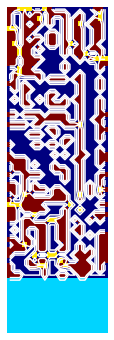

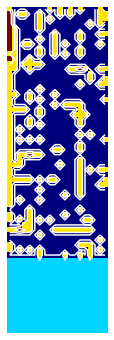

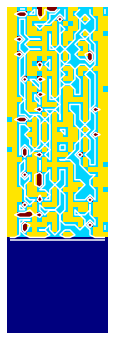

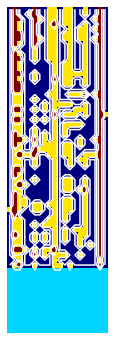

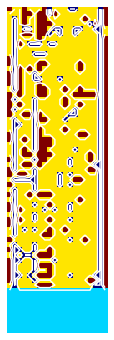

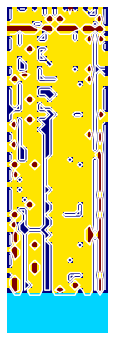

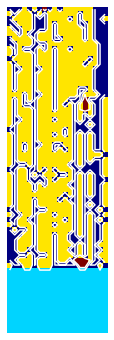

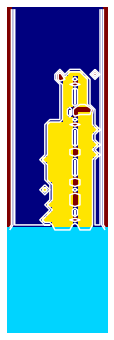

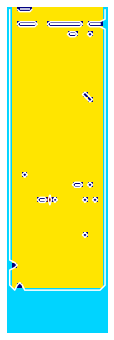

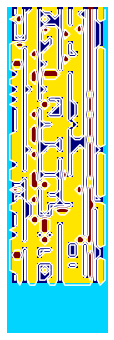

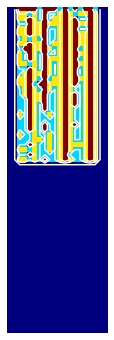

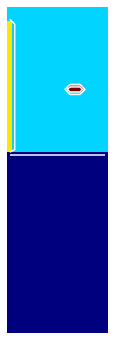

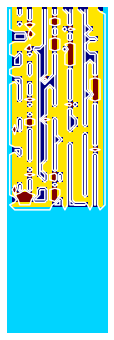

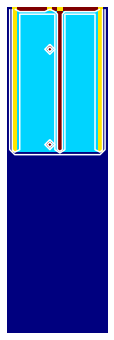

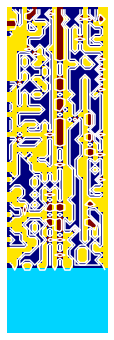

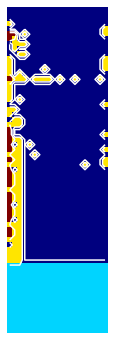

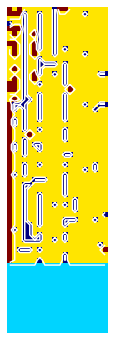

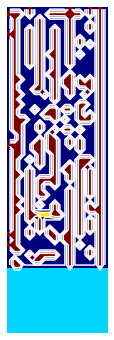

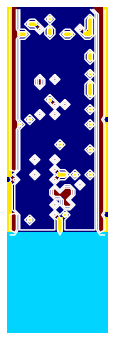

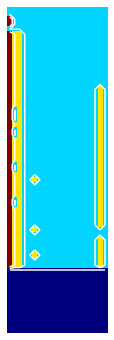

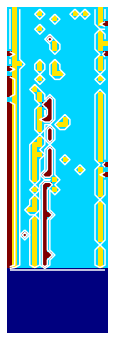

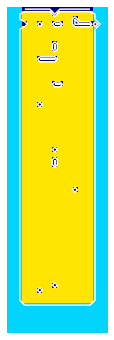

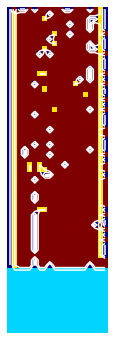

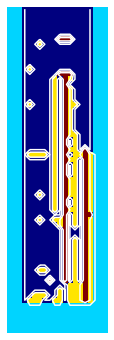

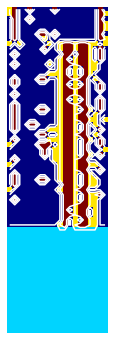

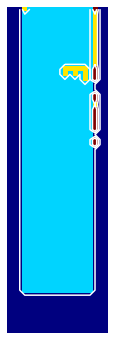

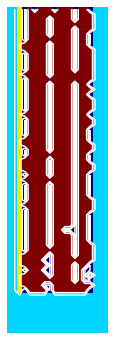

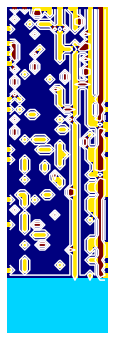

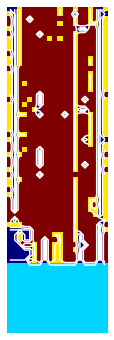

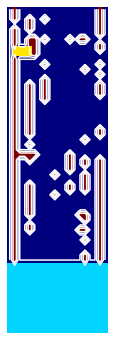

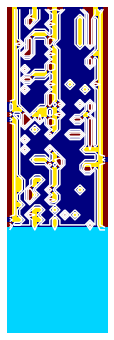

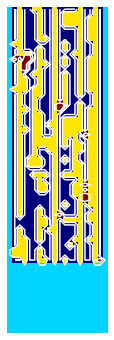

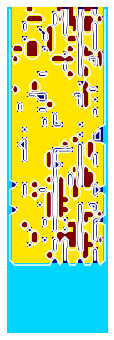

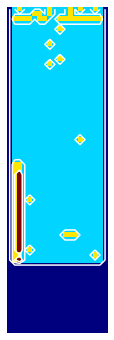

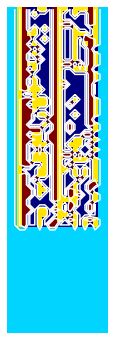

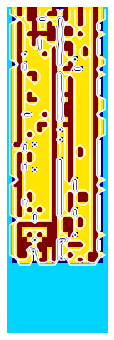

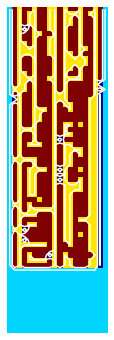

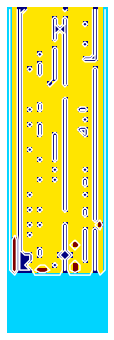

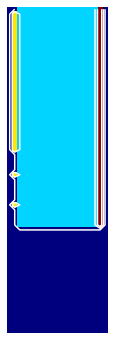

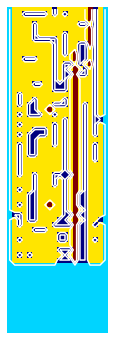

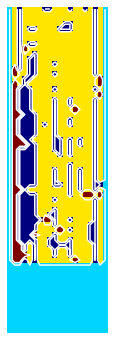

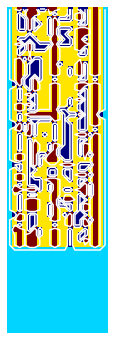

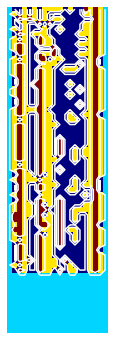

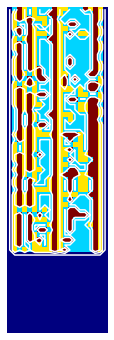

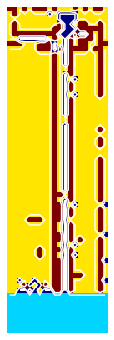

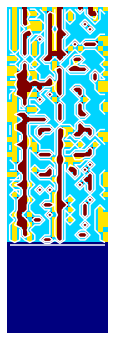

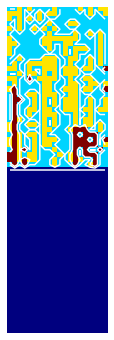

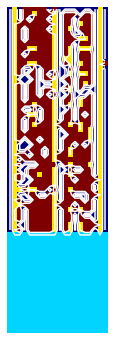

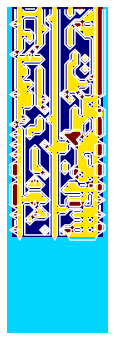

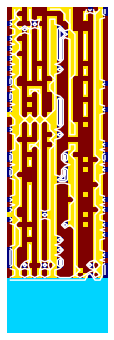

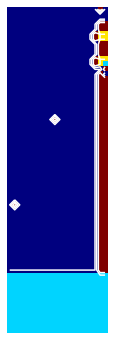

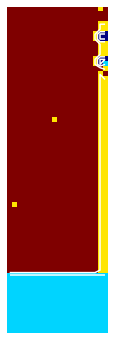

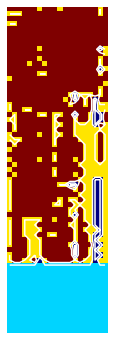

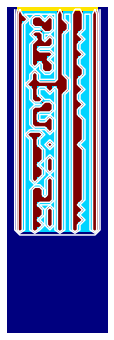

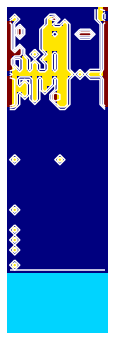

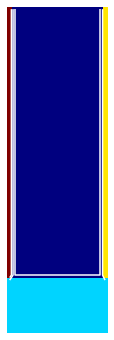

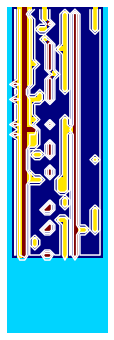

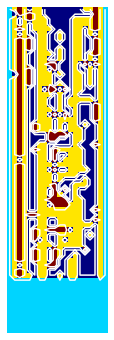

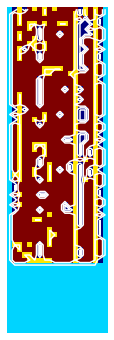

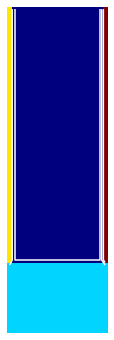

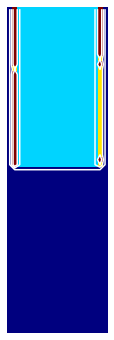

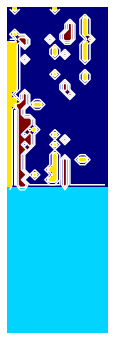

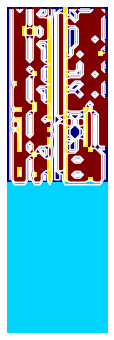

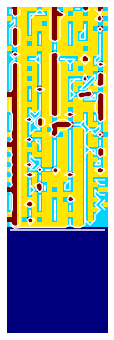

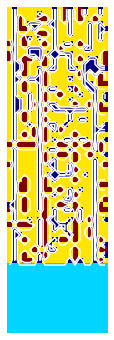

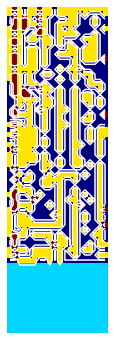

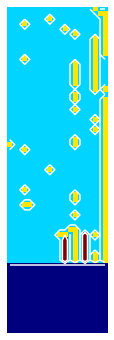

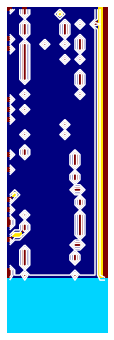

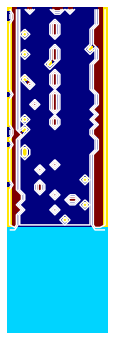

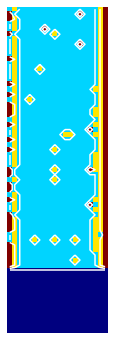

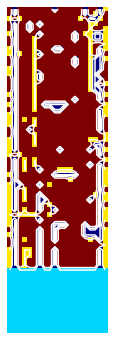

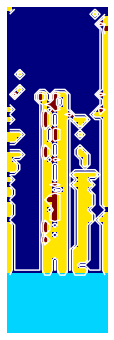

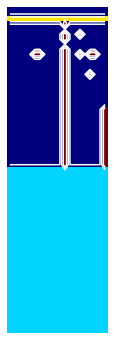

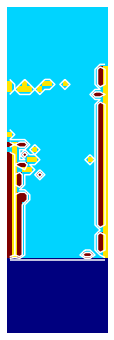

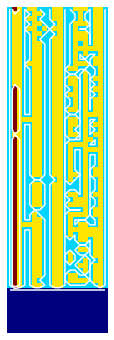

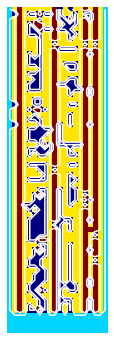

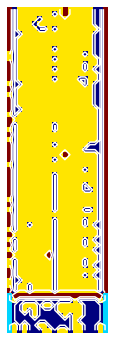

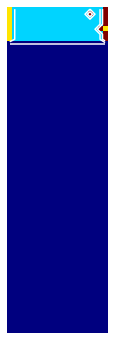

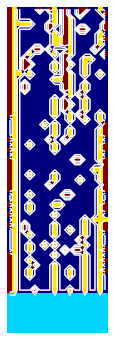

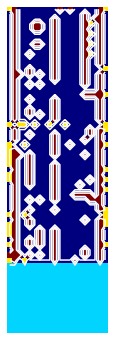

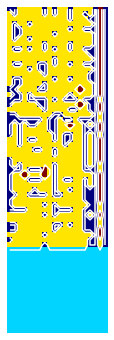

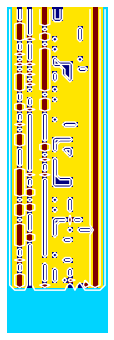

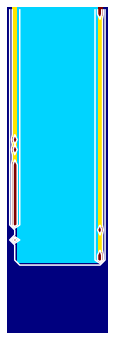

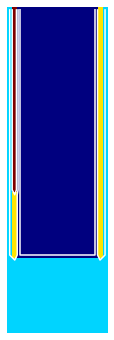

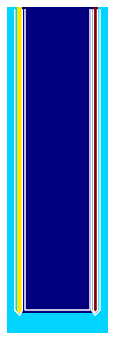

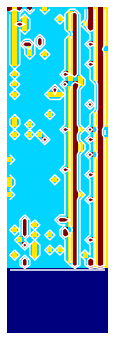

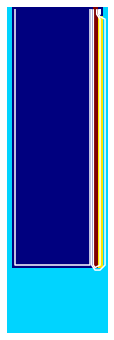

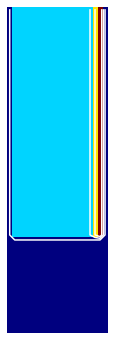

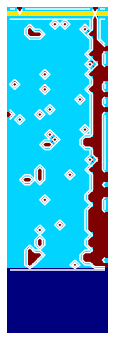

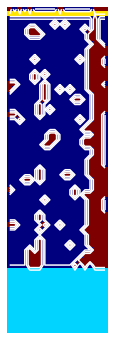

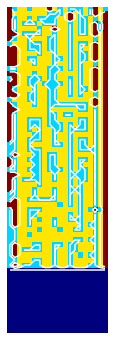

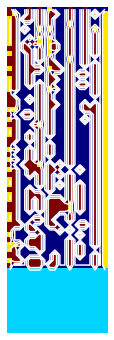

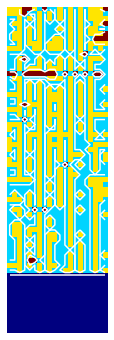

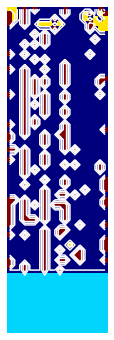

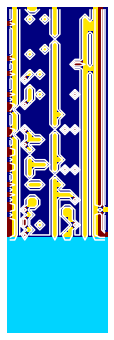

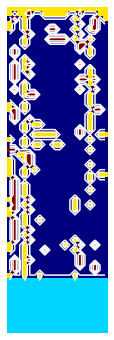

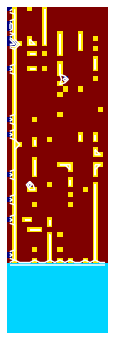

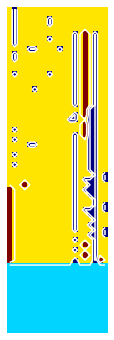

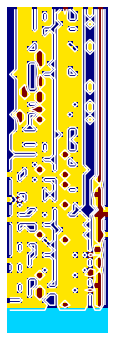

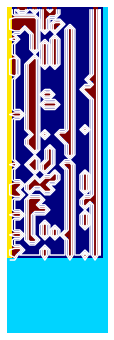

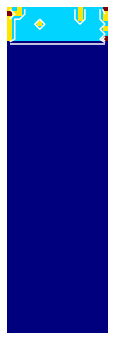

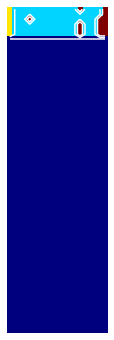

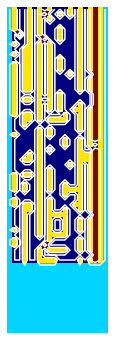

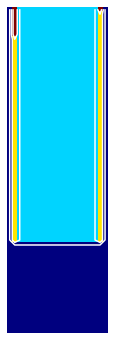

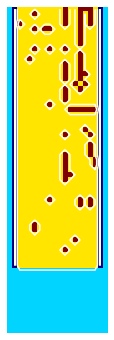

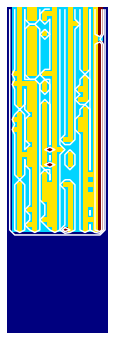

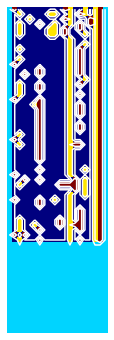

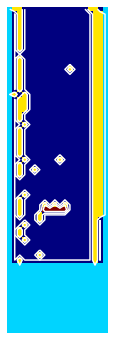

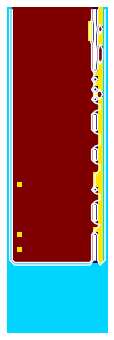

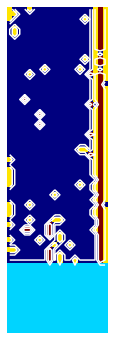

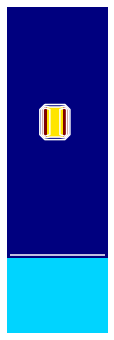

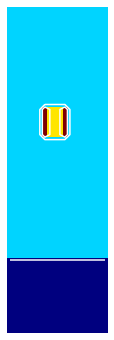

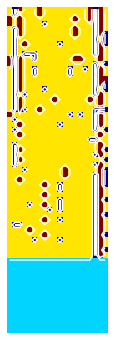

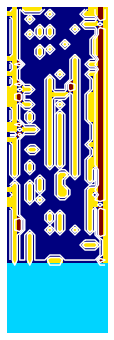

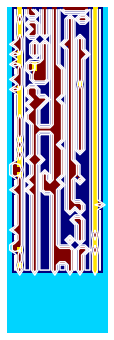

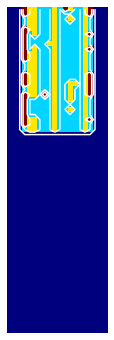

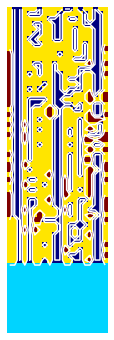

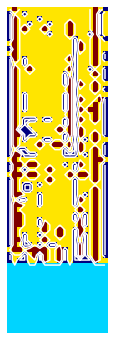

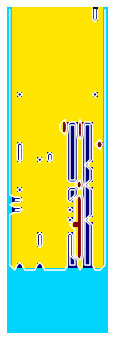

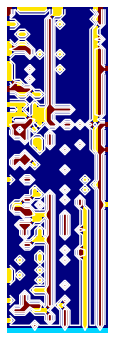

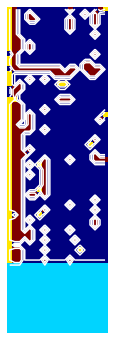

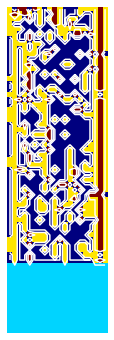

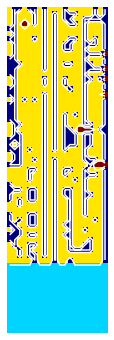

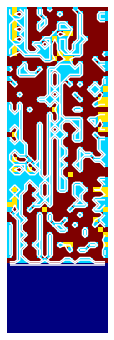

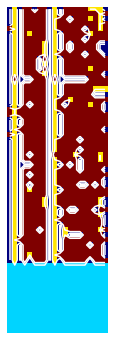

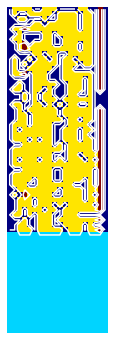

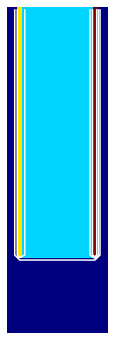

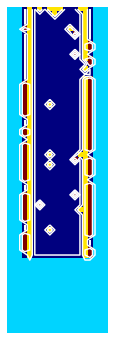

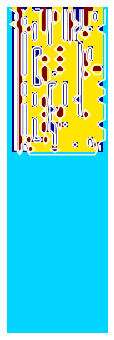

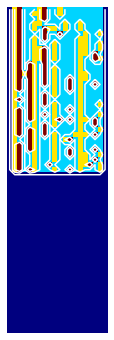

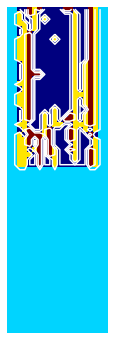

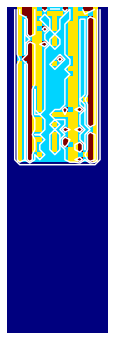

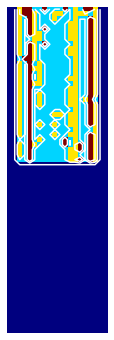

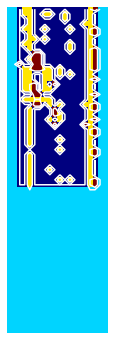

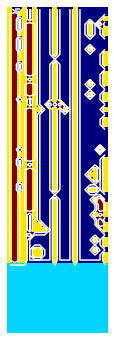

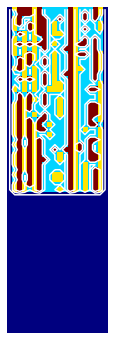

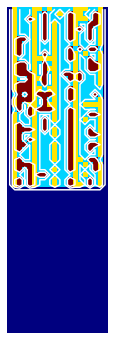

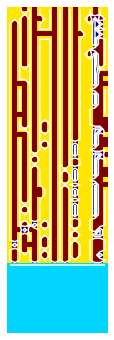

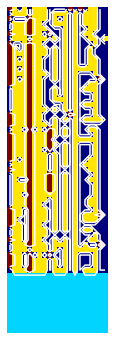

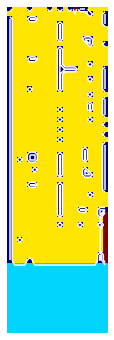

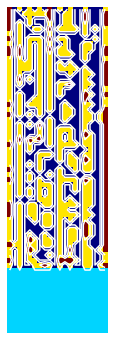

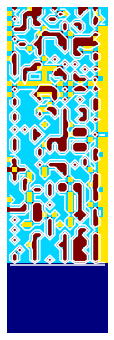

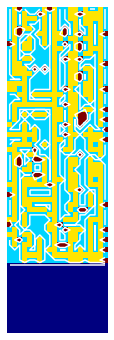

In [ ]:
from random import seed
seed(1)

segments = []
#Amostra supervised segmentation on images
i = 0
for i in range(len(tensores)):
  img = tensores[i]
  #_= plt.imshow(img)
  FIG_SIZE = (numpy.array(img.shape[:2]) / numpy.max(img.shape))[::-1]
  nb_classes = 4
  sp_size = 1
  sp_regul = 0.1
  dict_features = {'color': ['mean', 'std', 'median']}
  #modelo baseado na segmentação da imagme em classes
  model, _ = segm_pipe.estim_model_classes_group([img], nb_classes, sp_size=sp_size, sp_regul=sp_regul, 
                                          dict_features=dict_features, pca_coef=True, model_type='GMM')
  dict_debug = {}
  seg, _ = segm_pipe.segment_color2d_slic_features_model_graphcut(img, model, sp_size=sp_size, sp_regul=sp_regul,
                dict_features=dict_features, gc_regul=1., gc_edge_type='color', debug_visual=dict_debug)
  segments.append(seg)
  #fig = plt.figure(figsize=FIG_SIZE)
  print('Exemplo n°: ', str(i))
  #print(seg)
  #print('Classe: ', 'Approved' if y[i] == 1 else 'Disapproved', '\n', numpy.unique(seg, return_counts=True))
  fig = plt.figure()
  ax = plt.Axes(fig,[0,0,1,1])
  ax.set_axis_off()
  #fig.add_axes(ax)
  ax.imshow(img, filternorm= True)
  plt.imshow(seg, cmap=plt.cm.jet)
  plt.contour(seg, levels=numpy.unique(seg), colors='w')
  plt.axis('off')
  #plt.show()
  #plt.savefig("/content/drive/MyDrive/Filmes/example_{}.png".format(i),format='png')

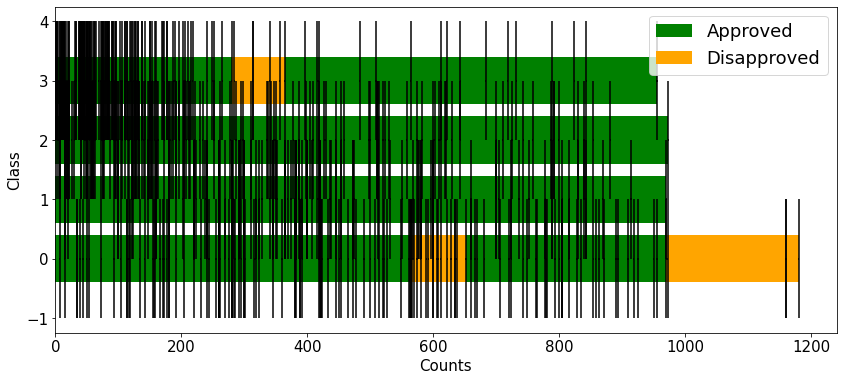

In [ ]:
lista_classes = []
i = 0
for i in range(len(segments)): 
  lista_classes.append(numpy.unique(segments[i], return_counts=True)[1])
i = 0
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams.update({'font.size': 15})
plt.xlabel("Counts")
plt.ylabel("Class")
for i in range(len(lista_classes)):
  plt.barh(numpy.unique(segments[i], return_counts=True)[0],lista_classes[i], color = 'green' if y[i] == 1 else 'orange', xerr = True, yerr = True, align = 'center', label = 'Approved' if y[i] == 1 else 'Disapproved')
  if i < 2:
    plt.legend(fontsize = 'large')

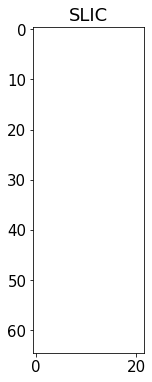

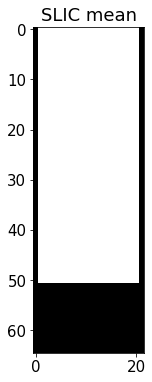

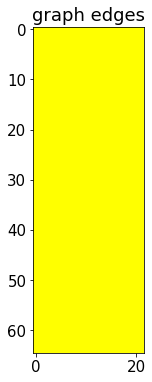

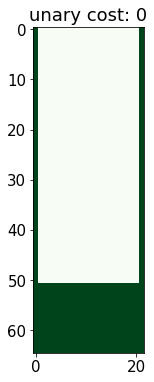

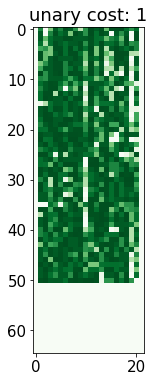

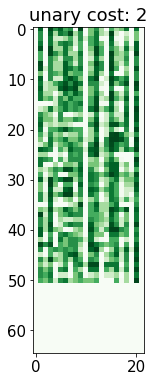

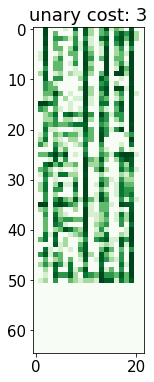

In [ ]:
plt.figure(), plt.imshow(mark_boundaries(tensores[i], dict_debug['slic'], color=(1, 1, 1))), plt.title('SLIC')
plt.figure(), plt.imshow(dict_debug['slic_mean']), plt.title('SLIC mean')
plt.figure(), plt.imshow(dict_debug['img_graph_edges']), plt.title('graph edges')
for i, im_u in enumerate(dict_debug['imgs_unary_cost']):
    plt.figure(), plt.title('unary cost: %i' % i), plt.imshow(im_u)

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from tensorflow.keras import regularizers
from random import seed
from tensorflow.keras import layers
seed(1)
batch_size = 2
num_classes = 2
epochs = 20

#dimensões de imagem
img_rows, img_cols = 65, 22

#configuração do formato dos dados para adaptação a rede neural
x_train, x_test, y_train, y_test = train_test_split(tensores,target,test_size=0.15,stratify= target)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
#Construção de modelo de rede neural de forma sequencial
model = Sequential()
model.reset_metrics()
layers.experimental.preprocessing.Rescaling(1./5, input_shape=(img_rows, img_cols, 1))
model.add(Conv2D(32, kernel_size=(3, 3),bias_regularizer=regularizers.l2(1e-1),
    activity_regularizer=regularizers.l2(1e-1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3),bias_regularizer=regularizers.l2(1e-1),
    activity_regularizer=regularizers.l2(1e-1), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu',bias_regularizer=regularizers.l2(1e-1),
    activity_regularizer=regularizers.l2(1e-1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu',
    bias_regularizer=regularizers.l2(1e-1),
    activity_regularizer=regularizers.l2(1e-1)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',
    bias_regularizer=regularizers.l2(1e-1),
    activity_regularizer=regularizers.l2(1e-1)))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#compilação da rede neural
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

img_input = layers.Input(shape=(65,22, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

x = layers.Conv2D(3, 2, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
#x = layers.Dropout(0.5)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(8, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
#x = layers.Conv2D(16, 3, activation='relu',kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l2(1e-5))(x)
#x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.5)(x)

**Trabalhos Futuros**



*   Analisar porcentagem das classes mostradas;
*   Determinar thresholds de porcentagem de classe para reprovação do produto
*   Identificação de padrões de falhas e classificação



